# **Training a CNN from scratch on a small dataset (using Data Augmentation)**

Having to train an image classification model using only very little data is a common situation, which you likely encounter yourself in practice.

As a practical example, we will focus on classifying images as "dogs" or "cats", in a dataset.

## Methods to be applied
1. training a new model from scratch (This example)
2. data augmentation, a powerful technique for mitigating overfitting (This example)
3. doing feature extraction with a pre-trained network (2 methods), later
4. fine-tuning a pre-trained network, later

Name: Urvashiben Thakkar

ID: 000789927

LTU Honor Code: I pledge that on all academic work that I submit, I neither gave nor received unauthorized aid, nor have I presented another person's work as my own.

## To access the datasets
<=== Click on the "folder" icon then click on the "Mount Drive". You will be also asked to run the following cell:

```
from google.colab import drive
drive.mount('/content/drive')
```

Check you see "cats_dogs_sm" folder.

In [ ]:
from google.colab import drive  # Importing the required module from Google Colab to mount Google Drive
drive.mount('/content/gdrive/') # Mounting Google Drive to the Colab notebook

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
# Directories
b_dir = '/content/gdrive/MyDrive/cats_dogs_sm' # Main Directory
train_dir = b_dir+'/train'                     # Directory for traing data
vali_dir = b_dir+'/validation'                 # Directory for validation data
test_dir = b_dir+'/test'                       # Directory for test data

train_cats_dir =b_dir+'/train/cats'           # Directory for training cats images
train_dogs_dir =b_dir+'/train/dogs'           # Directory for training dogs images
vali_cats_dir = b_dir+'/validation/cats'      # Directory for validation cats images
vali_dogs_dir = b_dir+'/validation/dogs'      # Directory for validation dogs images
test_cats_dir = b_dir+'/test/cats'            # Directory for test cats images
test_dogs_dir = b_dir+'/test/dogs'            # Directory for test dogs images

As a sanity check, let's count how many pictures we have in each training split (train/validation/test):

In [ ]:
import os, shutil
print('total training cat images:', len(os.listdir(train_cats_dir)))  # Total training cat images
print('total training dog images:', len(os.listdir(train_dogs_dir)))  # Total training dog images
print('total validation cat images:', len(os.listdir(vali_cats_dir))) # Total validation cat images
print('total validation dog images:', len(os.listdir(vali_dogs_dir))) # Total validation dog images
print('total test cat images:', len(os.listdir(test_cats_dir)))       # Total test cat images
print('total test dog images:', len(os.listdir(test_dogs_dir)))       # Total test dog images

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


So we have indeed 2K training images, and then 1K validation and 1K test images. In each split, there is the same number of samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate measure of success.



Building our network

This serves both to augment the capacity of the network, and to further reduce the size of the response(filtered) maps, so that they aren't overly large when we reach the Flatten layer. Here, since we start from inputs of size 299x299 (a somewhat arbitrary choice), we end up with feature maps of size 14x14 right before the Flatten layer.

Since we are attacking a binary classification problem, we are ending the network with a single unit (a Dense layer of size 1) and a sigmoid activation. This unit will encode the probability that the network is looking at one class or the other.

In [ ]:
from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers

# Define the input shape based on image size
def build_model():
  inputs = keras.Input(shape=(299, 299, 3))                           # The input layer with shape (299, 299, 3)
  x = layers.Rescaling(1./255)(inputs)                                # Preprocess inputs by rescaling pixel values to [0, 1]
  x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)  # Increased number of filters, kernel size 3
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
  x = layers.Flatten()(x)                                                 # Flatten the output to feed into the dense layer
  outputs = layers.Dense(1, activation="sigmoid")(x)                      # Output layer with sigmoid activation for binary classification
  model = keras.Model(inputs=inputs, outputs=outputs)                     # Create the model
  model.compile(                                                          # Compile the model with
      loss='binary_crossentropy',                                         # binary crossentropy loss
      optimizer=optimizers.RMSprop(learning_rate=1e-5),                   # RMSprop optimizer and change learning rate with 4 to 5
      metrics=['accuracy'])
  return model


In [ ]:
m = build_model() # Create an instance of the model using the build_model function
m.summary()       # Display a summary of the model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 297, 297, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 148, 148, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 128)       0         
 g2D)                                                        

Data preprocessing

As you know by now, data should be formatted into appropriately preprocessed floatingpoint tensors before being fed into the model. Currently, the data sits on a drive as JPEG files, so the steps for getting it into the model are roughly as follows:

Read the picture files.
Decode the JPEG content to RBG grids of pixels.
Convert these into floating point tensors.
Resize them to a shared size (we’ll use 299 × 299).
Pack them into batches (we’ll use batches of 32 images).
It may seem a bit daunting, but fortunately Keras has utilities to take care of these steps automatically. In particular, Keras features the utility function image_dataset_from_ directory(), which lets you quickly set up a data pipeline that can automatically turn image files on disk into batches of preprocessed tensors. This is what we’ll use here.

Calling image_dataset_from_directory(directory) will first list the subdirectories of directory and assume each one contains images from one of our classes. It will then index the image files in each subdirectory. Finally, it will create and return a tf.data.Dataset object configured to read these files, shuffle them, decode them to tensors, resize them to a shared size, and pack them into batches.

Default shuffle value is True. shuffle = True for train and validation. False for test.

In [ ]:
from keras.utils import image_dataset_from_directory
# shuffle is True by default
# class_mode='binary', better to specify?
train_dataset = image_dataset_from_directory(       # Load training dataset from the directory
    train_dir,                                      # Directory containing training images
    image_size=(299, 299),                          # Resize images to 299x299 pixels
    batch_size=32)                                  # Number of samples per batch
validation_dataset = image_dataset_from_directory(  # Load validation dataset from the directory
    vali_dir,                                       # Directory containing validation images
    image_size=(299, 299),                          # Resize images to 299x299 pixels
    batch_size=32)                                  # Resize images to 299x299 pixels
test_dataset = image_dataset_from_directory(        # Load test dataset from the director
    test_dir,                                       # Directory containing test images
    image_size=(299, 299),                          # Resize images to 299x299 pixels
    batch_size=32,                                  # Number of samples per batch
    shuffle=False)                                  # Disable shuffling since it's the test set

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.



Let’s look at the output of one of these Dataset objects: it yields batches of 299 × 299 RGB images (shape (32, 299, 299, 3)) and integer labels (shape (32,)). There are 32 samples in each batch (the batch size).

In [ ]:
for data_batch, labels_batch in train_dataset:       # Iterating over batches of data and labels from the training dataset
    print('data batch shape:', data_batch.shape)     # Printing the shape of the data batch (input images)
    print('labels batch shape:', labels_batch.shape) # Printing the shape of the labels batch (corresponding labels)
    break                                            # Exiting the loop after processing the first batch

data batch shape: (32, 299, 299, 3)
labels batch shape: (32,)


Let’s fit the model on our dataset. We’ll use the validation_data argument in fit() to monitor validation metrics on a separate Dataset object.

Note that we'll also use a ModelCheckpoint callback to save the model after each epoch. We'll configure it with the path specifying where to save the file, as well as the arguments save_best_only=True and monitor="val_loss": they tell the callback to only save a new file (overwriting any previous one) when the current value of the val_loss metric is lower than at any previous time during training. This guarantees that your saved file will always contain the state of the model corresponding to its bestperforming training epoch, in terms of its performance on the validation data. As a result, we won't have to retrain a new model for a lower number of epochs if we start overfitting: we can just reload our saved file.

Wht 63/63? In our case, batches are 32-sample large, so it will take 63 (ceiling of 2000/32=62.5) batches until we see our target of 2000 samples.

In [ ]:
callbacks = [                                                          # Define callbacks for the model
    keras.callbacks.ModelCheckpoint(
        #filepath="CNN4CatsDogs.keras",                                # saved in VM. To be deleted within a day
        filepath="/gdrive/MyDrive/history_files/CNN4CatsDogs.keras",   # Save the best model to Google Drive
        save_best_only=True,                                           # Save only the best model based on validation loss
        monitor="val_loss")                                            # Monitor validation loss for saving the best model
]
history = m.fit(                                                       # Train the model
    train_dataset,                                                     # Training dataset
    epochs=30,                                                         # Number of epochs for training
    validation_data=validation_dataset,                                # Validation dataset for evaluating model performance
    callbacks=callbacks)                                               # Callbacks to be applied during training

Epoch 1/30
63/63 [==============================] - 450s 7s/step - loss: 0.6928 - accuracy: 0.5060 - val_loss: 0.6916 - val_accuracy: 0.5620
Epoch 2/30
63/63 [==============================] - 19s 290ms/step - loss: 0.6916 - accuracy: 0.5310 - val_loss: 0.6909 - val_accuracy: 0.5790
Epoch 3/30
63/63 [==============================] - 18s 278ms/step - loss: 0.6902 - accuracy: 0.5340 - val_loss: 0.6913 - val_accuracy: 0.5010
Epoch 4/30
63/63 [==============================] - 19s 286ms/step - loss: 0.6893 - accuracy: 0.5575 - val_loss: 0.6891 - val_accuracy: 0.5700
Epoch 5/30
63/63 [==============================] - 19s 281ms/step - loss: 0.6875 - accuracy: 0.5690 - val_loss: 0.6878 - val_accuracy: 0.5810
Epoch 6/30
63/63 [==============================] - 20s 302ms/step - loss: 0.6857 - accuracy: 0.5775 - val_loss: 0.6875 - val_accuracy: 0.5300
Epoch 7/30
63/63 [==============================] - 19s 283ms/step - loss: 0.6837 - accuracy: 0.5825 - val_loss: 0.6838 - val_accuracy: 0.5870
E

In [ ]:
!ls '/gdrive/MyDrive/history_files/'

CNN4CatsDogs.keras


In [ ]:
print(history.history.keys())  # Print the keys available in the 'history' object, which contains training history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Let's plot the loss and accuracy of the model over the training and validation data during training:



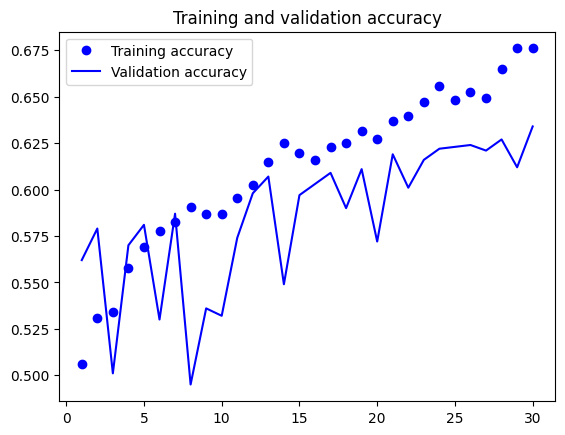

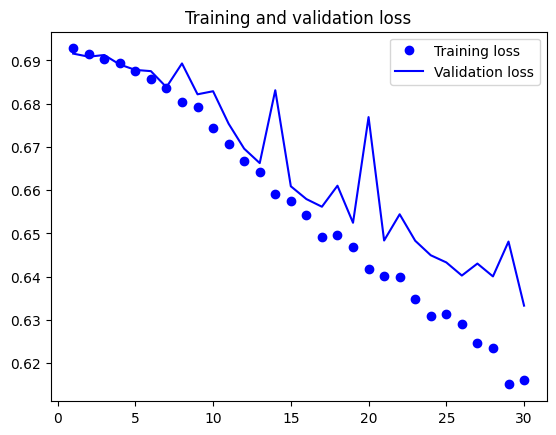

In [ ]:
import matplotlib.pyplot as plt
def plot_graphs4vali():
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  epochs = range(1, len(accuracy) + 1)
  plt.plot(epochs, accuracy, "bo", label="Training accuracy")
  plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
  plt.title("Training and validation accuracy")
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, "bo", label="Training loss")
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.legend()
  plt.show()

plot_graphs4vali()

These plots are characteristic of overfitting...

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. To mitigate overfitting, we will be using:

dropout - setting output of some neurons to zero
weight decay (L2 regularization) - after each update, the weights are multiplied by a factor slightly less than 1. This prevents the weights from growing too large.
data augmentation - specific to computer vision, and used almost universally when processing images with deep learning models:
By the way, let's evaluate the current model after reloading the model saved.

In [ ]:
test_model = keras.models.load_model("/gdrive/MyDrive/history_files/CNN4CatsDogs.keras")   # Load the pre-trained model from the specified filepath
test_loss, test_acc = test_model.evaluate(test_dataset)                                    # Evaluate the loaded model on the test dataset and get the test loss and accuracy
print(f"Test accuracy: {test_acc:.3f}")                                                    # Print the test accuracy rounded to 3 decimal places

32/32 [==============================] - 216s 7s/step - loss: 0.6420 - accuracy: 0.6200
Test accuracy: 0.620


Using Data Augmentation (DA)

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit.

Data augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number of random transformations that yield believable-looking images. The goal is that at training time for each epoch, our model would never see the exact same image twice. This helps the model get exposed to more aspects of the data and generalize better.

(OLD) In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our ImageDataGenerator instance.

In [ ]:
data_augmentation = keras.Sequential(             # Define data augmentation pipeline using a Sequential model
    [
        layers.RandomFlip("horizontal"),          # Randomly flip input images horizontally
        layers.RandomRotation(0.05),              # Randomly rotate input images by a maximum of 5% of the total image size
        layers.RandomZoom(0.3),                   # Randomly zoom input images by a maximum of 30%
    ]
)


These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

RandomFlip("horizontal")—Applies horizontal flipping to a random 50% of the images that go through it

RandomRotation(0.05)—Rotates the input images by a random angle within the range [-0.05 * 360 degrees, 0.05 * 360 degrees]. In degrees, this would be roughly [-18 degrees, +18 degrees]. This helps the model become more robust to variations in orientation.

RandomZoom(0.3)—Zooms into or out of the image by a random factor within the range [1 - 0.3, 1 + 0.3]. So, it can zoom in by up to 30% or zoom out by up to 30%.

width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.

shear_range is for randomly applying shearing transformations. See this

fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at some of our augmented images:

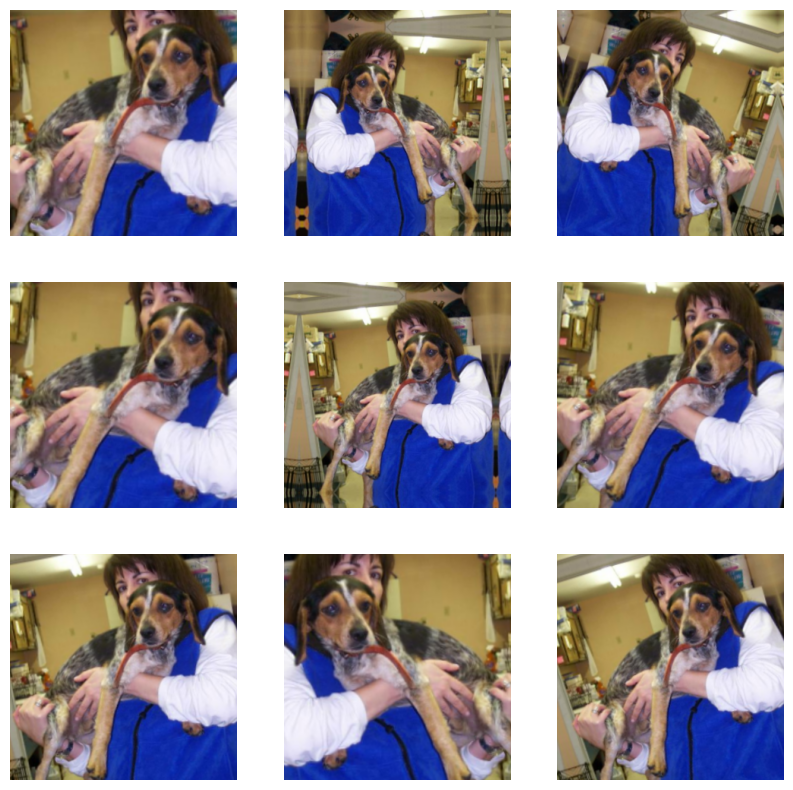

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

If we train a new model using this data-augmentation configuration, the model will never see the same input twice. But the inputs it sees are still heavily intercorrelated because they come from a small number of original images—we can’t produce new information; we can only remix existing information. As such, this may not be enough to completely get rid of overfitting. To further fight overfitting, we'll also add a Dropout layer to our model right before the densely connected classifier.

One last thing you should know about random image augmentation layers: just like Dropout, they're inactive during inference (when we call predict() or evaluate()). During evaluation, our model will behave just the same as when it did not include data augmentation and dropout.

Let's define a new convnet that includes image augmentation and dropout.

In [ ]:
inputs = keras.Input(shape=(299, 299, 3))
x = data_augmentation(inputs)                                       # Apply data augmentation to the input images
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
m_da = keras.Model(inputs=inputs, outputs=outputs)                   # the model2(m_da) with data augmentation
m_da.compile(loss="binary_crossentropy",
# optimizer="rmsprop",
optimizer=optimizers.RMSprop(learning_rate=1e-5), # learning rate
metrics=["accuracy"])


In [ ]:
# Define callbacks for the model, saving the best model based on validation loss
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="CNN4CatsDogs_DA.keras",    # Save the model with data augmentation to this filepath
        save_best_only=True,                 # Save only the best model based on validation loss
        monitor="val_loss")                  # Monitor validation loss for saving the best model
    ]
history = m_da.fit(                          # Train the model with data augmentation
    train_dataset,                           # Training dataset
    epochs=100,                              # Number of epochs for training
    validation_data=validation_dataset,      # Validation dataset for evaluating model performance
    callbacks=callbacks)                      # Callbacks to be applied during training

Epoch 1/100
63/63 [==============================] - 23s 308ms/step - loss: 0.6925 - accuracy: 0.5005 - val_loss: 0.6918 - val_accuracy: 0.5410
Epoch 2/100
63/63 [==============================] - 19s 291ms/step - loss: 0.6921 - accuracy: 0.5180 - val_loss: 0.6912 - val_accuracy: 0.5790
Epoch 3/100
63/63 [==============================] - 20s 309ms/step - loss: 0.6908 - accuracy: 0.5420 - val_loss: 0.6908 - val_accuracy: 0.5360
Epoch 4/100
63/63 [==============================] - 20s 308ms/step - loss: 0.6902 - accuracy: 0.5475 - val_loss: 0.6889 - val_accuracy: 0.5660
Epoch 5/100
63/63 [==============================] - 21s 304ms/step - loss: 0.6886 - accuracy: 0.5530 - val_loss: 0.6881 - val_accuracy: 0.5580
Epoch 6/100
63/63 [==============================] - 20s 298ms/step - loss: 0.6870 - accuracy: 0.5655 - val_loss: 0.6857 - val_accuracy: 0.5750
Epoch 7/100
63/63 [==============================] - 20s 294ms/step - loss: 0.6852 - accuracy: 0.5735 - val_loss: 0.6836 - val_accuracy:

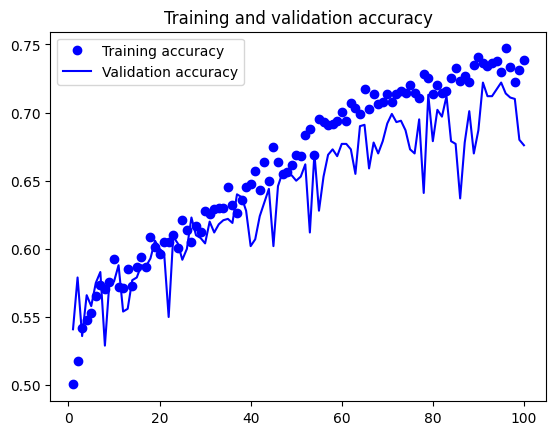

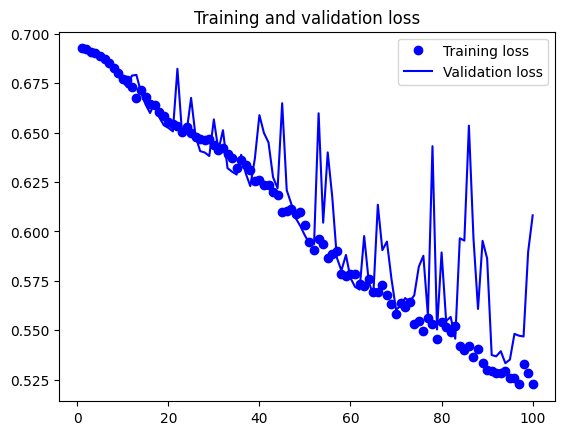

In [ ]:
plot_graphs4vali()

Display some test images and present them to the model.

In [ ]:
# To get the 1st batch from test dataset
for test_data_batch, test_labels_batch in test_dataset:
    print('test_data batch shape:', test_data_batch.shape)
    print('test_labels batch shape:', test_labels_batch.shape)
    break
#print(test_data_batch[0]) #float32

test_data batch shape: (32, 299, 299, 3)
test_labels batch shape: (32,)


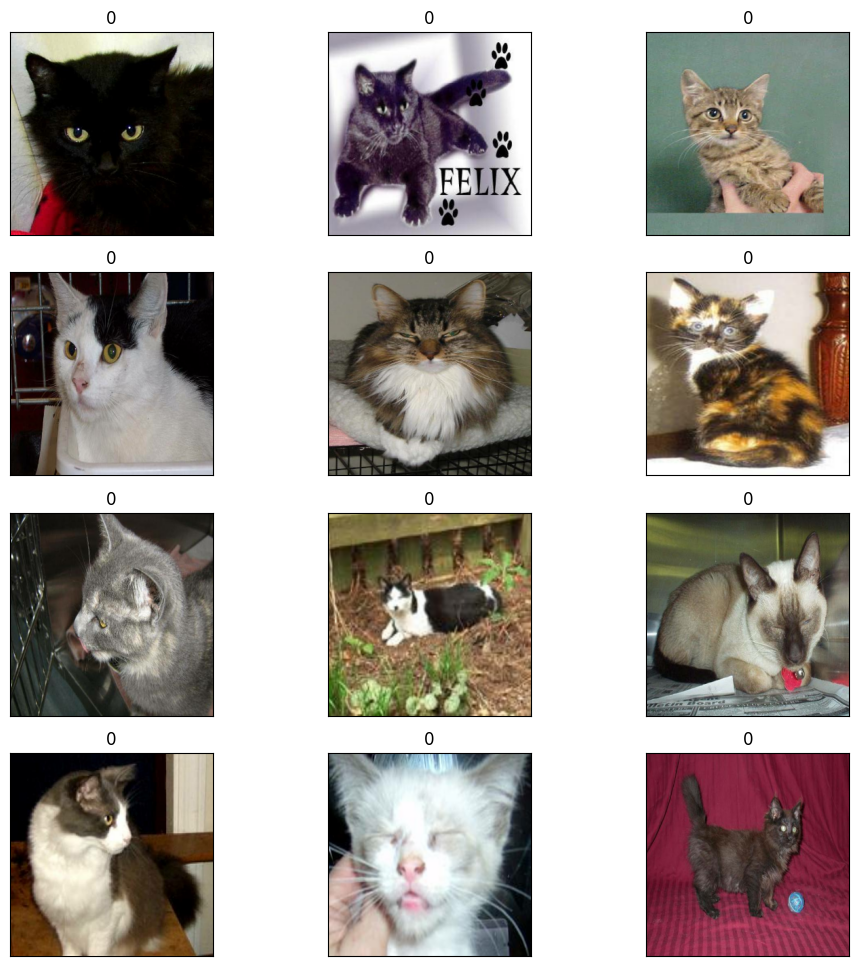

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.tight_layout()
  plt.imshow(test_data_batch[i].numpy().astype("uint8"))
  plt.title(f"{test_labels_batch[i]}")
  plt.xticks([])
  plt.yticks([])

In [ ]:
import numpy as np
print("target labels:     ", np.array(test_labels_batch))
# present the image to the network
out = m_da.predict(test_data_batch, verbose=0)
out = out.reshape(32,)
print("prediected labels: ", out.round().astype("uint8"))

target labels:      [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
prediected labels:  [0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1]


Evaluate 2 models

DA showed a little improvement here.

In [ ]:
test_loss, test_acc = test_model.evaluate(test_dataset)          # Evaluate the pre-trained model without data augmentation on the test dataset
print(f"Test accuracy without DA: {test_acc:.3f}")
test_model_da = keras.models.load_model("CNN4CatsDogs_DA.keras")  # Load the model trained with data augmentation
test_loss, test_acc = test_model_da.evaluate(test_dataset)        # Evaluate the model with data augmentation on the test dataset
print(f"Test accuracy with    DA: {test_acc:.3f}")

32/32 [==============================] - 5s 152ms/step - loss: 0.6420 - accuracy: 0.6200
Test accuracy without DA: 0.620
32/32 [==============================] - 4s 127ms/step - loss: 0.5614 - accuracy: 0.7250
Test accuracy with    DA: 0.725


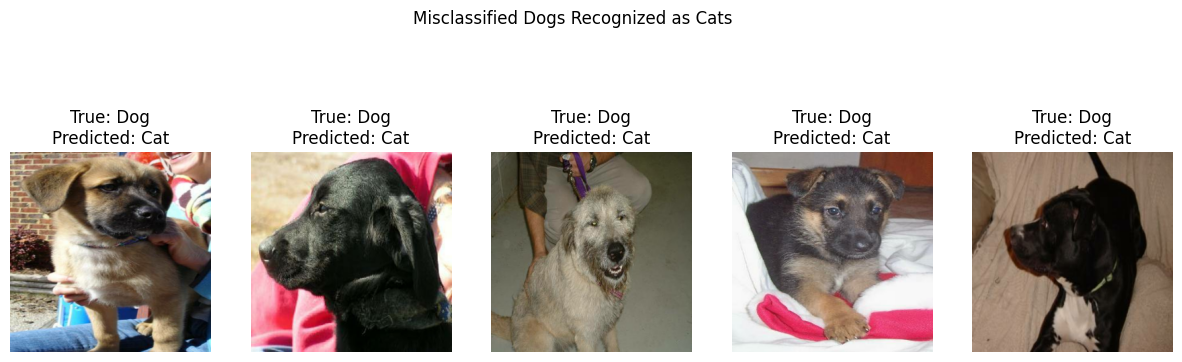

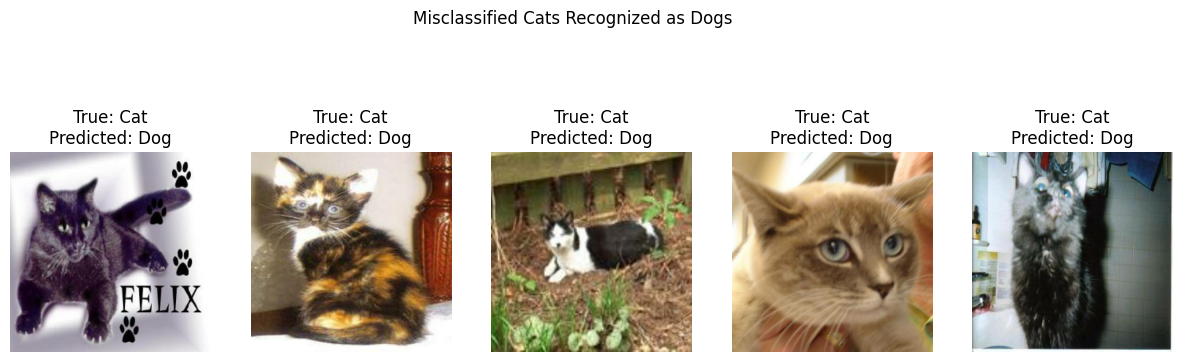

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define class names
class_names = ['Cat', 'Dog']

# Initialize lists to store misclassified images and labels
misclassified_dog_as_cat = []
misclassified_cat_as_dog = []

# Counter variables to track the number of misclassified images
dog_as_cat_count = 0
cat_as_dog_count = 0

# Iterate through the test dataset
for test_data_batch, test_labels_batch in test_dataset:
    # Predict using the model
    predictions = m_da.predict(test_data_batch, verbose=0).flatten()
    predicted_labels = np.round(predictions).astype("uint8")

    # Identify misclassified dogs as cats
    for idx, label in enumerate(test_labels_batch.numpy()):
        if label == 1 and predicted_labels[idx] == 0:  # Dog misclassified as cat
            misclassified_dog_as_cat.append(test_data_batch[idx].numpy())
            dog_as_cat_count += 1
            if dog_as_cat_count >= 5:
                break

    # Identify misclassified cats as dogs
    for idx, label in enumerate(test_labels_batch.numpy()):
        if label == 0 and predicted_labels[idx] == 1:  # Cat misclassified as dog
            misclassified_cat_as_dog.append(test_data_batch[idx].numpy())
            cat_as_dog_count += 1
            if cat_as_dog_count >= 5:
                break

    # Break if we have found enough misclassifications
    if dog_as_cat_count >= 5 and cat_as_dog_count >= 5:
        break

# Display misclassified images of dogs recognized as cats
plt.figure(figsize=(15, 5))
for i, image in enumerate(misclassified_dog_as_cat[:5]):
    plt.subplot(1, 5, i + 1)
    plt.imshow(image.astype("uint8"))
    plt.title(f"True: Dog\nPredicted: Cat")
    plt.axis("off")
plt.suptitle("Misclassified Dogs Recognized as Cats")
plt.show()

# Display misclassified images of cats recognized as dogs
plt.figure(figsize=(15, 5))
for i, image in enumerate(misclassified_cat_as_dog[:5]):
    plt.subplot(1, 5, i + 1)
    plt.imshow(image.astype("uint8"))
    plt.title(f"True: Cat\nPredicted: Dog")
    plt.axis("off")
plt.suptitle("Misclassified Cats Recognized as Dogs")
plt.show()


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Feb 28 20:09:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   78C    P0              34W /  70W |  14077MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


# CNN architecture changes:  

### Input Shape:

Model Input shape is (299, 299, 3).

### Model Architecture:

Begins with a larger input size (299x299).
Employs a series of Conv2D layers with increasing filter sizes (64, 128, 256, 512, 512).
Each Conv2D layer uses a kernel size of 3x3.
Uses MaxPooling2D layers to downsample the spatial dimensions after each convolutional layer.

## Number of Parameters:

The model generally has more parameters due to the larger input size and higher number of filters in some layers. This can potentially make model expressive and capable of capturing more complex patterns in the data. However, it also increases computational complexity and memory requirements.

## Output Layer:

A single neuron in the output layer with a sigmoid activation function, suitable for binary classification tasks.

Data Augmentation parameter changes:

Randomly flips images horizontally are the same.

Randomly rotates images by up to 5% of the total width or height.

Randomly zooms into images by up to 30%.

## Dropout rate changes affect the models:

Droup out 0.5 during training, half of the neurons will be randomly dropped out, effectively reducing the capacity of the network. This dropout rate is relatively high, which can lead to more aggressive regularization, potentially reducing the risk of overfitting. However, it might also slow down the training process as the network needs to learn to be robust to randomly missing neurons.

while in my model, the dropout rate is lower, at 0.2. This means that during training, each neuron in the dropout layers has a 20% probability of being dropped out. Compared to the 0.5 model, this dropout rate is less aggressive, allowing more information to flow through the network during training. While still providing regularization, it might be less likely to hinder the learning process compared to a higher dropout rate like 0.5.

